# Copying rectangular memory regions in OpenCL


It sometimes may be necessary to copy only rectangular subregions of memory spaces to and from OpenCL buffers. This is particularly useful when partitioning spaces between OpenCL devices. The OpenCL standard specifies three functions to accomplish copies between host memory and OpenCL buffer, namely [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueReadBufferRect.html) and [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueWriteBufferRect.html). The function [clEnqueueCopyBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueCopyBufferRect.html) copies rectangular regions between two OpenCL buffers that share a context. In this example we will copy a portion of a rectangular grid to an OpenCL buffer, make a change to the buffer, then copy the buffer back to the grid. Shown in yellow in the figure below is a cartoon of the region that we intend to modify.

<figure style="float:center">
    <img style="display:inline-block; vertical-align:top; margin:20px" src="images/copy_rect_region.png" width="40%">
    <figcaption style= "text-align:lower; margin:2px; float:bottom; vertical-align:bottom">Figure: Area to be modified is in yellow </figcaption>
</figure>

## Running the code

[Here](code/copy_rect_region.cpp) is the source code for the example. Essentially we have copied the matrix multiplication example and made a few modifications for use with the **clEnqueueWriteBufferRect** and **clEnqueueReadBufferRect** functions. If you are using Linux you can run **make** and it should compile the program **copy_rect_region**. The program reads in a (1024,1024) matrix of 32-bit floats from the file [array_A_1D.dat](code/array_A_1D.dat), modifies the matrix, and writes it back out to the file [array_A_1D_modified.dat](code/array_A_1D_modified.dat). We generate the input matrix file using the following Python code:

In [3]:
# Code to make the test file
import numpy as np
import os

nrows=1024
ncols=1024

# Make up some arrays of random numbers
matrix_A=np.random.random((nrows, ncols)).astype(np.float32)

# Write the files to grid, notice how I unravel in column major (f) format
# before writing to file
matrix_A.ravel(order="f").tofile(os.path.join("code","array_A_1D.dat"))

Now run the program **copy_rect_region** in the same directory where the file **array_A_1D.dat** is saved. The output can now be checked with the following Python code

<IPython.core.display.Javascript object>


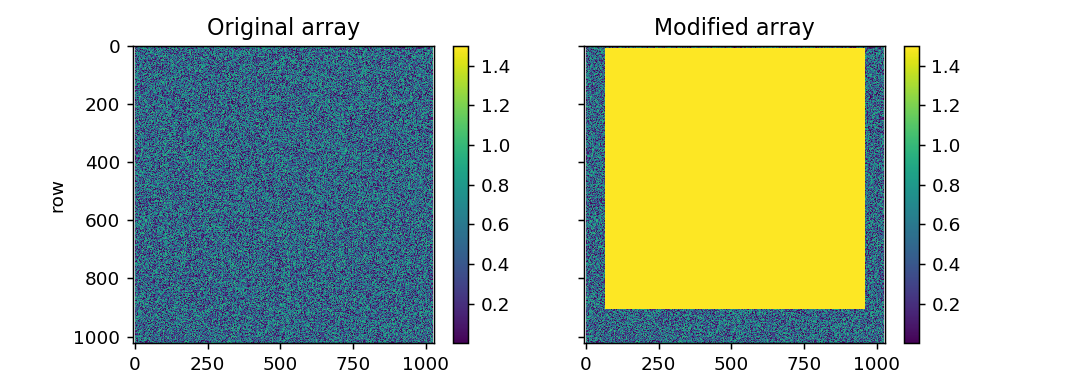

In [5]:
### Checking the result
import numpy as np
import os
import matplotlib.pyplot as plt
% matplotlib notebook

# Read in the two arrays
nrows=1024
ncols=1024

array_A=np.fromfile(os.path.join("code","array_A_1D.dat"), dtype=np.float32)
array_A=array_A.reshape((nrows,ncols), order="f")
array_A_mod=np.fromfile(os.path.join("code","array_A_1D_modified.dat"), dtype=np.float32)
array_A_mod=array_A_mod.reshape((nrows,ncols), order="f")

# Plot the arrays and check the answer
[fig, ax]=plt.subplots(1,2, figsize=(8,2.9), sharex=True, sharey=True)
im1=ax[0].imshow(array_A, interpolation="nearest", vmin=np.min(array_A_mod), vmax=np.max(array_A_mod))
fig.colorbar(im1,ax=ax[0])
ax[0].set_title("Original array")
ax[0].set_ylabel("row")
im2=ax[1].imshow(array_A_mod, vmin=np.min(array_A_mod), vmax=np.max(array_A_mod), interpolation="nearest")
fig.colorbar(im2,ax=ax[1])
ax[1].set_title("Modified array")
plt.show()

## How it works

The code is very much the same as the matrix multiplication example, but with the buffer copy functions changed to [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueReadBufferRect.html) and [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueWriteBufferRect.html). Understanding what parameters to feed into [clEnqueueReadBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueReadBufferRect.html) and [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueWriteBufferRect.html) is a bit complex and the documentation doesn't make it easy. Essentially you have to understand that these functions don't know the data type and that you have to explicitly specify the size of the memory region you are copying. Shown below is the code from a call to [clEnqueueWriteBufferRect](https://www.khronos.org/registry/OpenCL/sdk/1.2/docs/man/xhtml/clEnqueueWriteBufferRect.html)  from line 332 of [copy_rect_region.cpp](code/copy_rect_region.cpp).

```C
errchk(clEnqueueReadBufferRect(    command_queue,
                        buffer_A,
                        CL_TRUE,
                        buffer_origin,
                        host_origin,
                        region,
                        buffer_row_pitch,
                        buffer_slice_pitch,
                        host_row_pitch,
                        host_slice_pitch,
                        array_A_1D,
                        0,
                        NULL,
                        NULL), "Reading from buffer_A to host");
```

**buffer_A** is going to be the size of the yellow region in the above plot. We specify the size of that buffer and where it begins using the following code:

```C
// Specify the size of the input matrix 
size_t nrows=1024;
size_t ncols=1024;
size_t element_size=sizeof(float);
size_t nelements=nrows*ncols;
size_t nbytes=nelements*element_size;

// Size of the OpenCL buffer and the number of bytes it should contain
size_t nrows_buffer=nrows-128;
size_t ncols_buffer=ncols-128;
size_t nbytes_buffer=nrows_buffer*ncols_buffer*element_size;

// Starting positions for the rectangular region to be copied
size_t row_origin=10;
size_t col_origin=64;
```

Recall that coordinates in OpenCL arrays are arranged in Fortran ordering. The order is (row, column, slice), where row is the fastest dimension and elements are contiguously arranged in memory along that dimension.  


The 3-element *size_t* arrays **buffer_origin** and **host_origin** specify the starting locations for memory in the buffer and on the host. Beware that the first element of these arrays is the offset in *number of bytes* along a column. The second element is the offset in *number of columns*, and the third is the offset in *number of slices*. For 1D and 2D data there is of course only 1 slice, so the slice offset is 0. Given the row and column origin information we create **buffer_origin** and **host_origin** as follows:

```C
// Buffer origin is {0,0,0} because we are not accessing a subregion of the buffer
// Remember origin has units of (nbytes, ncolumns, nslices)
size_t buffer_origin[3]={0,0,0};
size_t host_origin[3]={row_origin*element_size,col_origin,0};
```

Next we specify the size of the region to be copied. As with the host and buffer origin arrays, **region** is a 3-element array of type *size_t*. The first element is number of bytes to be copied along a column, the second  element is the number of columns, and the third element is the number of slices to copy within the rectangular region. Unlike the offset arrays above, every element of **region** must be at least 1, so for copies of 2D regions, the last element of **region** is going to be 1.

```C
// Size of the region to be copied (nbytes, ncols, nslices)
size_t region[3]={nrows_buffer*element_size, ncols_buffer, 1};
```

Now we need to let the function know how many bytes are in a column and a slice for both the host and buffer arrays. It sounds awfully confusing, but **buffer_row_pitch** is the number of bytes in a column (or the number of bytes along the "row" dimension) of the buffer, and **buffer_slice_pitch** is the number of bytes in a slice. The same is true with **host_row_pitch** and **host_slice_pitch**.

```C
// Row pitch is the number of bytes in a column
size_t buffer_row_pitch=nrows_buffer*element_size;
size_t host_row_pitch=nrows*element_size;

// Slice pitch is the number of bytes in a slice
size_t buffer_slice_pitch=ncols_buffer*buffer_row_pitch;
size_t host_slice_pitch=ncols*host_row_pitch;
```

The calls to both **clEnqueueWriteBufferRect** and **clEnqueueReadBufferRect** are virtually identical, so it is not beneficial to repeat the above explanation for when the data is put back into the host array using **clEnqueueReadBufferRect**.

<address>
&copy; 2018 by Dr. Toby Potter<br>
email: <a href="mailto:tobympotter@gmail.com">tobympotter@gmail.com</a><br>
Visit us at: <a href="https://www.pelagos-consulting.com">www.pelagos-consulting.com</a><br>
</address>